# What Does the Housing Market in Hawaii Look Like in 2020?
_Author: Zeth De Luna &mdash; September 21, 2020_

Hawaii is known for its beautiful culture, delicious food, and that feeling of paradise anywhere you go in the islands. It's no wonder why people are looking to Hawaii when they're trying to escape the hustle and bustle of the typical American city. If you're in the market to buy a home in Hawaii, hopefully this article will give you a little more insight into the prices and what the average house looks like in your price range.

We're going to analyze data on housing in Hawaii that I scraped from [Zillow.com](https://www.zillow.com/), a popular American online real estate marketplace that allows consumers to explore their potential new home with the help of pictures, current market prices, rooms, square-footage, and more. The data (available in [my repository](https://github.com/zethdeluna/Hawaii-Housing-Market-2020)) contains information on Zillow listings in Hawaii that were available on September 21st of 2020. We're going to use this data to train and test various regression models to predict the price of a house given its features (number of bedrooms/bathrooms, square-footage, location).

__Results:__ We were able to train a model that predicts the price of a property in Hawaii with an $R^2$ value around 0.75 using housing features including: type (Condo, House, Studio, or Townhouse), square-footage, number of bedrooms/bathrooms, and location (street, city, and zipcode).

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np

# sci-kit learn libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# laker colors
purple = (85/255, 37/255, 130/255)
gold = (253/255, 185/255, 39/255)
blue = (121/255, 163/255, 220/255)
lakers = [purple, gold, blue]
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Read in the Data

In [2]:
col_names = ['address', 'url', 'type', 'price', 'bedrooms', 'bathrooms', 'sqft']
listings = pd.read_csv('hawaii_listings_2020.csv', names=col_names, header=0)
listings.head()

,address,url,type,price,bedrooms,bathrooms,sqft
0,"1221 Victoria St APT 1101, Honolulu, HI 96814",https://www.zillow.com/homedetails/1221-Victor...,Condo for sale,"$199,000.00",2 bds,2 ba,"1,692 sqft"
1,"4999 Kahala Ave APT 265, Honolulu, HI 96816",https://www.zillow.com/homedetails/4999-Kahala...,Condo for sale,"$39,900.00",2 bds,2 ba,"1,258 sqft"
2,"5621 Kalanianaole Hwy, Honolulu, HI 96821",https://www.zillow.com/homedetails/5621-Kalani...,House for sale,"$6,995,000.00",7 bds,6 ba,"6,689 sqft"
3,"1007 Koko Kai Pl, Honolulu, HI 96825",https://www.zillow.com/homedetails/1007-Koko-K...,House for sale,"$2,400,000.00",4 bds,4 ba,"3,400 sqft"
4,"1221 Victoria St APT 2404, Honolulu, HI 96814",https://www.zillow.com/homedetails/1221-Victor...,Condo for sale,"$265,000.00",2 bds,3 ba,"1,586 sqft"


## Exploratory Analysis (Part 1)
Here's a list of the feature definitions in the data that we have:
* `address`: house address&mdash;includes street, city, state and zip code
* `url`: link to the house on [zillow.com](https://www.zillow.com/)
* `type`: type of property, i.e. house, condo, townhouse, etc.
* `price`: current market price of the listing
* `bedrooms`: number of bedrooms in the listing
* `bathrooms`: number of bathrooms in the listing
* `sqft`: square-footage of the listing

### Missing Data

In [3]:
listings.isnull().sum()

address        0
url            0
type           0
price          0
bedrooms       0
bathrooms    340
sqft         340
dtype: int64

#### `bedrooms`

In [4]:
listings[~listings['bedrooms'].str.contains('bds|bd')]['bedrooms'].value_counts()

Studio             102
3 acres lot         15
1 acres lot         14
2 acres lot          7
0.5 acres lot        6
                  ... 
6.88 acres lot       1
2.43 acres lot       1
8.5 acres lot        1
4.36 acres lot       1
13.32 acres lot      1
Name: bedrooms, Length: 218, dtype: int64

* There are many listings with the area of the property under the `bedrooms` feature, we should look into this further.
* There are bedrooms listed as 'Studio', which we'll address later.

#### `bathrooms`

In [5]:
listings[listings['bathrooms'].isnull()]['type'].value_counts()

Lot / Land for sale    324
For sale by owner       12
Foreclosure              4
Name: type, dtype: int64

In [6]:
listings[listings['bathrooms'].isnull()]['bedrooms'].value_counts()

3 acres lot        15
1 acres lot        14
2 acres lot         7
5 acres lot         6
0.5 acres lot       6
                   ..
46.61 acres lot     1
6.88 acres lot      1
2.43 acres lot      1
8.5 acres lot       1
13.32 acres lot     1
Name: bedrooms, Length: 217, dtype: int64

* It appears that all listings with missing bathroom numbers are listings for plots of land, which we won't be interested in.

#### `sqft`

In [7]:
listings[listings['sqft'].isnull()]['type'].value_counts()

Lot / Land for sale    324
For sale by owner       12
Foreclosure              4
Name: type, dtype: int64

* The missing `sqft` values correspond to the missing bathroom values.

## Initial Data Cleaning
Before we can properly perform exploratory analysis, we need to convert some of the features to a numerical type.

### Removing Lots

In [8]:
# remove listings for lots
listings = listings[~listings['bedrooms'].str.contains('lot')]

### Removing Auctions
Auctions by nature are constantly changing in price, so we should remove those listings.

In [9]:
# remove auction listings
listings = listings[~(listings['type'] == 'Auction')]

### `price`

In [10]:
listings[~listings['price'].str.contains('.00')]['price'].value_counts()

Est. $669,816    1
Est. $425,349    1
Est. $562,191    1
Name: price, dtype: int64

We'll need to:
* replace `$--` with a proper missing value (`NaN`)
* remove `Est.` from the beginning of some values
* replace `K` with `000` (some prices represent "thousands" with "K")

Once we handle those values, we can convert the entire feature after removing the dollar signs and commas.

Note: we found that some missing values in the `price` column are not counted as missing because they are represented by `--`. This could mean that there might be missing values in other columns that weren't counted.

In [11]:
# replace '$--' with 'NaN'
listings.loc[listings['price'].str.contains('-'), 'price'] = np.nan

# remove 'Est.' and replace 'K' with '000'
listings['price'] = (listings['price']
                         .str.replace('Est. ', '')
                         .str.replace('K', ',000')
                    )
# remove '$' and ',' then convert feature to float
listings['price'] = (listings['price']
                         .str.replace('\$|,', '')
                         .astype(float)
                    )

### `sqft`

In [12]:
listings[listings['sqft'].str.contains('-')]['sqft'].value_counts()

-- sqft    20
Name: sqft, dtype: int64

* The `sqft` feature has some hidden missing values that we should replace with `NaN`
* After that, we can remove the 'sqft' and ',' strings, and convert values to float

In [13]:
# replace hidden missing values with NaN
listings.loc[listings['sqft'].str.contains('-'), 'sqft'] = np.nan

# remove 'sqft' and ',' and convert to float
listings['sqft'] = (listings['sqft']
                        .str.replace(',| sqft', '')
                        .astype(float)
                   )

### `bathrooms`

In [14]:
listings[listings['bathrooms'].str.contains('-')]['bathrooms'].value_counts()

-- ba    28
Name: bathrooms, dtype: int64

In [15]:
# replace '-- ba' with NaN
listings.loc[listings['bathrooms'].str.contains('-'), 'bathrooms'] = np.nan

# remove ' ba' and convert to float
listings['bathrooms'] = (listings['bathrooms']
                             .str.replace(' ba', '')
                             .astype(float)
                        )

### `bedrooms`

In [16]:
listings[listings['bedrooms'].str.contains('-')]['bedrooms'].value_counts()

Series([], Name: bedrooms, dtype: int64)

* The `bedrooms` column doesn't have any hidden missing values, but we need to handle the `Studio` listings before we can convert the feature to a numerical data type.

In [17]:
listings['bedrooms'].value_counts()

3 bds     873
2 bds     591
4 bds     449
1 bd      265
5 bds     199
Studio    102
6 bds      84
7 bds      39
8 bds      21
9 bds       5
10 bds      4
11 bds      2
12 bds      1
15 bds      1
18 bds      1
47 bds      1
24 bds      1
29 bds      1
Name: bedrooms, dtype: int64

### Studios
The most common definition of a studio is a living area that has no physical separation between the bedroom, bathroom, kitchen, and living room. So, by definition, studios can only have 1 bedroom and most likely only 1 bathroom.

To distinguish studios from the other housing types, we'll replace: studio listings'
* `type` value with `Studio`
* `bedrooms` value with `1 bd`
* `bathrooms` value with `1`

In [18]:
# get 'Studio' listings indices
studio_index = listings[listings['bedrooms'] == 'Studio'].index

# set type to 'Studio'
listings.loc[studio_index, 'type'] = 'Studio'

# set bedrooms to 1 bd
listings.loc[studio_index, 'bedrooms'] = '1 bd'

# set bathrooms to 1 ba
listings.loc[studio_index, 'bathrooms'] = 1.0

In [19]:
# convert bedrooms to float
listings['bedrooms'] = (listings['bedrooms']
                            .str.replace(' bds| bd', '')
                            .astype(float)
                       )

### `type`

In [20]:
listings['type'].value_counts()

House for sale        1559
Condo for sale         779
Studio                 102
Townhouse for sale      68
For sale by owner       54
Foreclosure             33
New construction        25
Apartment for sale      16
Pre-foreclosure          2
Foreclosed               2
Name: type, dtype: int64

* There are some housing types that don't exactly state what kind of property the listing is for (everything listed below `Townhouse for sale` above). We can try to find out what kind of listings they are (and de-clutter the `type` values) by manually checking each listing on Zillow.

#### `For sale by owner`

In [21]:
# listing types were saved in a separate .csv file
for_sale_by_owner = pd.read_csv('for_sale_by_owner.csv', index_col='Index')

# replace 'For sale by owner' values with property type with the corresponding index
for index in for_sale_by_owner.index:
    listings.loc[index, 'type'] = for_sale_by_owner.loc[index, 'type']

#### `New construction`

In [22]:
# listing types were saved in a separate .csv file
new_construction = pd.read_csv('new_construction.csv', index_col=0)

# replace 'New construction' values
for index in new_construction.index:
    listings.loc[index, 'type'] = new_construction.loc[index, 'type']
    
# new_construction.csv introduced a new housing type called 'weird' -- drop that
listings = listings[~(listings['type'] == 'weird')]

#### `Foreclosure` / `Pre-foreclosure` / `Foreclosed`
Houses that have been foreclosed tend to be incredibly run-down and out of shape, driving their values down. These listings may not accurately represent the housing prices in Hawaii, so we'll take those listings out.

In [23]:
# remove any foreclosed properties
listings = listings[~listings['type'].str.contains('oreclos')]

In [24]:
listings['type'].value_counts()

House for sale        1559
Condo for sale         779
Studio                  99
Townhouse for sale      68
House                   51
Condo                   19
Apartment for sale      16
Townhouse               10
Name: type, dtype: int64

#### `Apartment for sale`
Upon further investigation on Zillow.com, the listings that are listed as `Apartment for sale` are entire apartment complexes for sale. This is something we don't need in our analysis, so we'll remove those listings.

In [25]:
# remove apartment complex listings
listings = listings[~(listings['type'] == 'Apartment for sale')]

In [26]:
listings['type'].value_counts()

House for sale        1559
Condo for sale         779
Studio                  99
Townhouse for sale      68
House                   51
Condo                   19
Townhouse               10
Name: type, dtype: int64

#### Cleaning the types

In [27]:
# remove 'for sale' at the end of some listing types
listings['type'] = (listings['type']
                        .str.replace('for sale', '')
                        .str.strip()
                   )

In [28]:
listings['type'].value_counts()

House        1610
Condo         798
Studio         99
Townhouse      78
Name: type, dtype: int64

## Exploratory Analysis (Part 2)
Questions to consider:
1. Does the number of bedrooms have a relationship with the price?
2. Does the number of bathrooms have a relationship with the price?
3. Does the square-footage have a relationship with the price?
4. Does the type of listing (house, condo, etc.) have a relationship with the price?

### Missing Values

In [29]:
listings.isnull().sum()

address       0
url           0
type          0
price         0
bedrooms      0
bathrooms     1
sqft         20
dtype: int64

In [30]:
# the listing with the missing amount of bathrooms
listings[listings['bathrooms'].isnull()]

,address,url,type,price,bedrooms,bathrooms,sqft
1097,"4933 Kahekili Hwy, Wailuku, HI 96793",https://www.zillow.com/homedetails/4933-Kaheki...,House,5295000.0,4.0,NaN,4707.0


In [31]:
# some listings with missing sqft
listings[listings['sqft'].isnull()].head()

,address,url,type,price,bedrooms,bathrooms,sqft
166,"1888 Kalakaua Ave #505, Honolulu, HI 96815",https://www.zillow.com/homedetails/1888-Kalaka...,Studio,50000.0,1.0,1.0,NaN
552,"4730 Halehoola Pl, Honolulu, HI 96816",https://www.zillow.com/homedetails/4730-Haleho...,Studio,1000000.0,1.0,1.0,NaN
683,"1560 Kanunu St #B-95, Honolulu, HI 96814",https://www.zillow.com/homedetails/1560-Kanunu...,Studio,30000.0,1.0,1.0,NaN
688,"66-025 Alapii St, Haleiwa, HI 96712",https://www.zillow.com/homedetails/66-025-Alap...,Studio,695000.0,1.0,1.0,NaN
1637,"5013 Moa Rd APT C, Kapaa, HI 96746",https://www.zillow.com/homedetails/5013-Moa-Rd...,Condo,785000.0,4.0,4.0,NaN


* We can fill the missing bathroom value by comparing the listing to other listings of the same size and finding the most common number of bathrooms within those listings.
* Filling the missing square-footage values will be a little bit trickier.

### Does the number of bedrooms have a relationship with the price?

In [32]:
def clean_axes(axis):
    for spine in ['top', 'left', 'right']:
        axis.spines[spine].set_visible(False)
    axis.tick_params(length=0, labelleft=False)

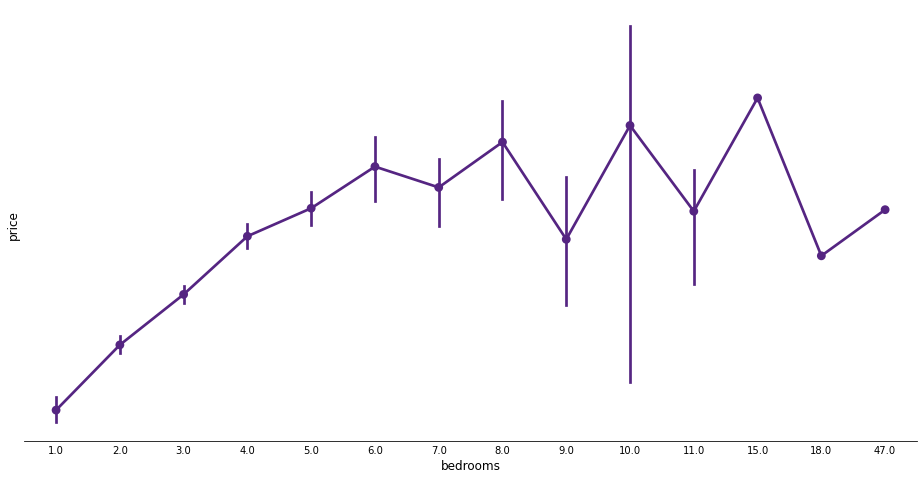

In [33]:
fig, ax = plt.subplots(figsize=(16,8))
plt.yscale('symlog')
clean_axes(ax)
ax.set_xlabel('bedrooms', fontsize=12)
ax.set_ylabel('price', fontsize=12)

ax = sns.pointplot('bedrooms', 'price', data=listings, color=purple)
plt.show()

* The price fluctuates for houses over 6 bedrooms, but there is a general upward trend for the price as the number of bedrooms increases.
* There is a very large difference between highest price and lowest price among houses with 10 bedrooms.

### Does the number of bathrooms have a relationship with the price?

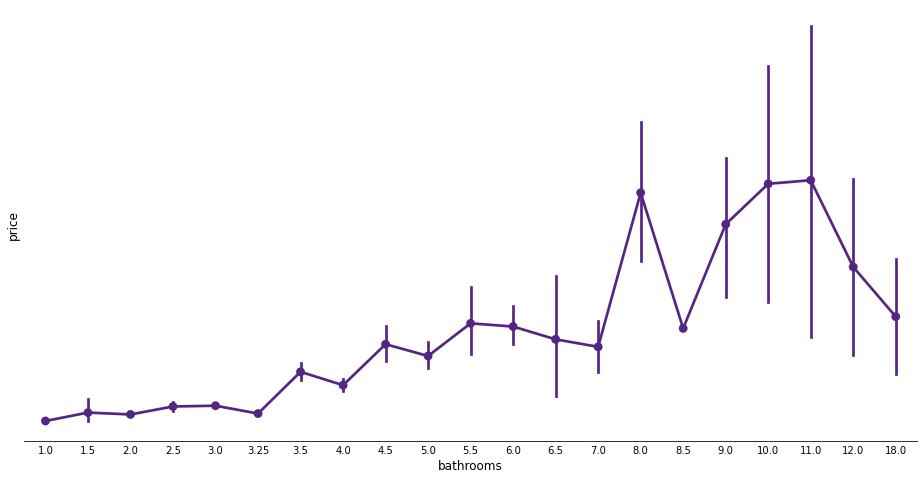

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
clean_axes(ax)

ax.set_xlabel('bathrooms', fontsize=12)
ax.set_ylabel('price', fontsize=12)

ax = sns.pointplot('bathrooms', 'price', data=listings, color=purple)
plt.show()

* Listings with 1 - 3.25 bathrooms are around the same price.
* Listings with 3.5 - 7 bathrooms are around the same price, with some outliers at 5.5 and 6.5 bathrooms.
* Listings with over 8 bathrooms have the highest prices, but can include some listings in the price range of properties with 3.5 - 7 bathrooms.

### Does the square-footage have a relationship with the price?

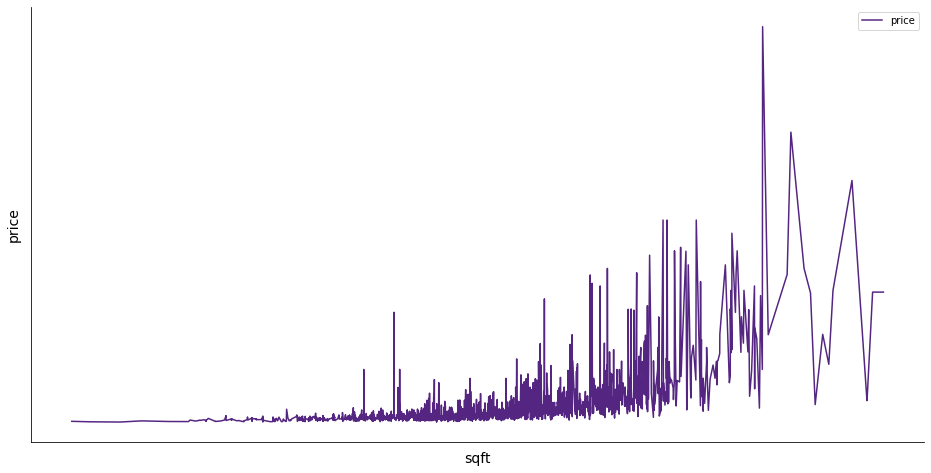

In [35]:
# sort the listings by sqft
sorted_sqft = listings.dropna().sort_values('sqft').copy()

fig, ax = plt.subplots(figsize=(16,8))
plt.xscale('symlog')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.tick_params(length=0, labelleft=False, labelbottom=False)
ax.set_xlabel('sqft', fontsize=14, labelpad=10)
ax.set_ylabel('price', fontsize=14, labelpad=10)

sorted_sqft.plot(kind='line', x='sqft', y='price', ax=ax, color=purple)

plt.show()

* Listings with lower square-footage tend to have lower prices.
* As the square-footage increases, there is a higher chance for a listing to have a high price. However, there are still listings with high square-footage _and_ a low price. For this reason, there may be a very weak correlation between square-footage and price.

### Does the type of listing (house, condo, etc.) have a relationship with the price?

In [36]:
listings['type'].value_counts()

House        1610
Condo         798
Studio         99
Townhouse      78
Name: type, dtype: int64

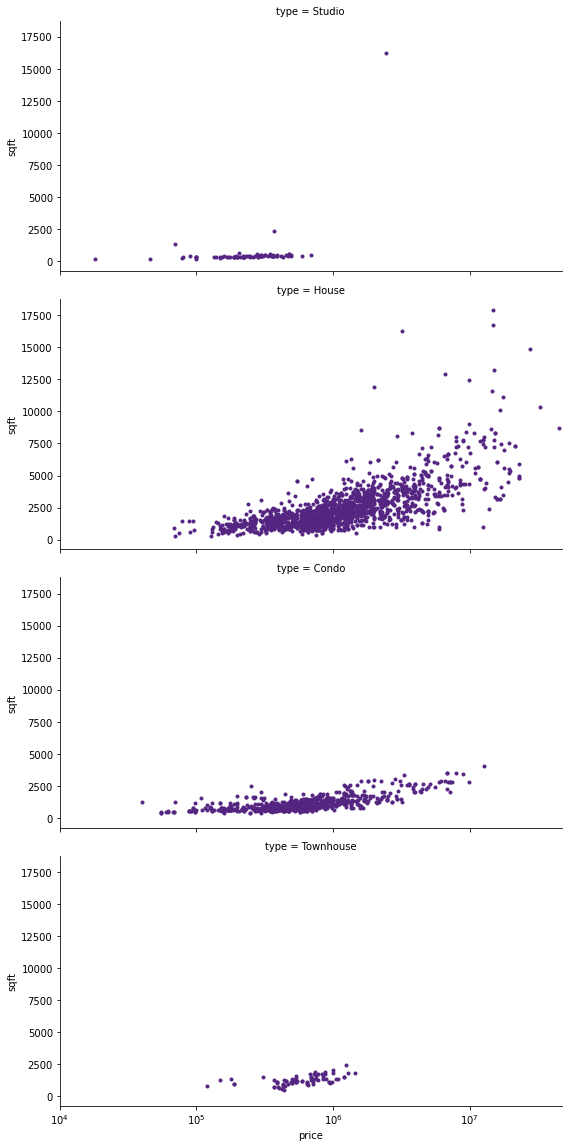

In [37]:
grid = sns.FacetGrid(sorted_sqft, row='type', height=4, aspect=2)
grid.map(plt.scatter, 'price', 'sqft', color=purple, marker='.')
plt.xscale('symlog')
grid.set(xlim=(1e4, None))
plt.show()

* Most studio listings range between \\$100,000 and \\$1,000,000, with some outliers.
* Most townhouse listings range between \\$500,000 and \\$3,000,000.
* House and condo listings have a wide range of prices.

## Data Preprocessing
### `bathrooms`

In [38]:
listings[listings['bathrooms'].isnull()]

,address,url,type,price,bedrooms,bathrooms,sqft
1097,"4933 Kahekili Hwy, Wailuku, HI 96793",https://www.zillow.com/homedetails/4933-Kaheki...,House,5295000.0,4.0,NaN,4707.0


In [39]:
# get other listings with similar bedrooms and sqft
bed4_sqft4700 = listings[(listings['bedrooms'] == 4) & (listings['sqft'] > 4500) & (listings['sqft'] < 4900)].copy()

# fill missing bathrooms value with the mode
listings.loc[listings['bathrooms'].isnull(), 'bathrooms'] = bed4_sqft4700['bathrooms'].mode()[0]

### `sqft`

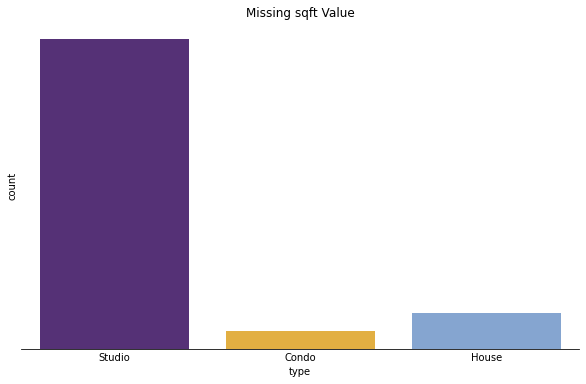

In [40]:
# count the types of listings with missing sqft value
fig, ax = plt.subplots(figsize=(10,6))
clean_axes(ax)
ax.set_title('Missing sqft Value')

ax = sns.countplot(x='type', data=listings[listings['sqft'].isnull()], palette=lakers)

plt.show()

#### _Studios_

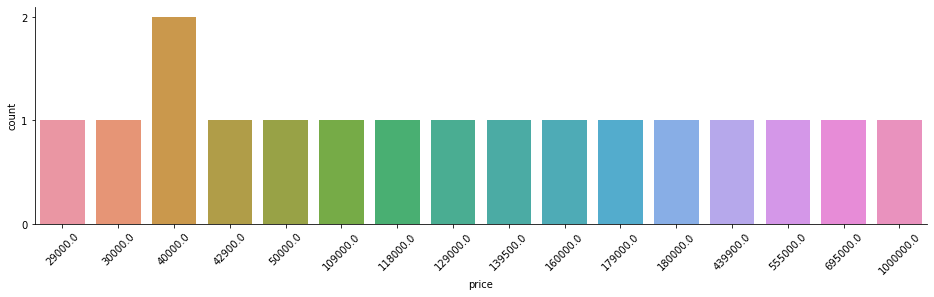

In [41]:
# isolate studio listings with missing sqft
studios_nosqft = listings[(listings['sqft'].isnull()) & (listings['type'] == 'Studio')]

fig, ax = plt.subplots(figsize=(16,4))
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
plt.locator_params(axis='y', nbins=3)
plt.xticks(rotation=45)

ax = sns.countplot(x='price', data=studios_nosqft)

* Studios tend to have a lower price, but there are few that are relatively expensive (over \\$400,000). Upon further investigation, it was found that those expensive listings are for large lots of land, one being empty and the rest having a tiny unit. Let's get rid of those listings.
* For the rest of the studios, we can fill the missing values by comparing them to other studios with similar prices.

In [42]:
# get index of studios over $400,000
studios_over400k = studios_nosqft[studios_nosqft['price'] > 400000].index

# remove those listings
listings.drop(studios_over400k, axis=0, inplace=True)

In [43]:
# isolate all studios
studios = listings[listings['type'] == 'Studio'].dropna().copy()

# studios below $60,000
studios[studios['price'] < 60000]

,address,url,type,price,bedrooms,bathrooms,sqft
793,"1288 Kapiolani Blvd #S344W, Honolulu, HI 96814",https://www.zillow.com/homedetails/1288-Kapiol...,Studio,45800.0,1.0,1.0,160.0
2267,"Seadrift Rd, Pahoa, HI 96778",https://www.zillow.com/homedetails/Seadrift-Rd...,Studio,18000.0,1.0,1.0,192.0


* There are only 2 studio listings that are below \\$60,000. To avoid introducing any bias, we'll fill the square-footage of studios under \\$60,000 with random values between 150 sqft and 200 sqft.

In [44]:
# fill missing sqft in studios that cost less than $60,000 with random values between 150sqft and 200sqft
studios_below60K_nosqft = (listings['type'] == 'Studio') & (listings['sqft'].isnull()) & (listings['price'] < 60000)
listings.loc[studios_below60K_nosqft, 'sqft'] = np.random.randint(150, 200, size=6)

In [45]:
# studios between $100,000 and $200,000
studios[(studios['price'] > 1e5) & (studios['price'] < 2e5)]

,address,url,type,price,bedrooms,bathrooms,sqft
495,"134 Kapahulu Ave #403, Honolulu, HI 96815",https://www.zillow.com/homedetails/134-Kapahul...,Studio,149000.0,1.0,1.0,218.0
777,"2947 Kalakaua Ave APT 703, Honolulu, HI 96815",https://www.zillow.com/homedetails/2947-Kalaka...,Studio,149000.0,1.0,1.0,350.0
1368,"2180 W Vineyard St APT 200, Wailuku, HI 96793",https://www.zillow.com/homedetails/2180-W-Vine...,Studio,195000.0,1.0,1.0,389.0
1690,"4331 Kauai Beach Dr #1326, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,169000.0,1.0,1.0,320.0
1691,"4331 Kauai Beach Dr #1116, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,135000.0,1.0,1.0,320.0
1795,"4331 Kauai Beach Dr #1308, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,189000.0,1.0,1.0,320.0
1806,"4331 Kauai Beach Dr #1118, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,139000.0,1.0,1.0,320.0
2038,"4331 Kauai Beach Dr #2412, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,199000.0,1.0,1.0,307.0
2042,"4331 Kauai Beach Dr #2419, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,168000.0,1.0,1.0,320.0
2048,"4331 Kauai Beach Dr #1317, Lihue, HI 96766",https://www.zillow.com/homedetails/4331-Kauai-...,Studio,155000.0,1.0,1.0,320.0


* From a quick scan, we see that most studios within that price range are 320 sqft. So, we'll fill in the remainder of the missing studio sqft values with 320.

In [46]:
# fill remainder of studios' missing sqft values
listings.loc[(listings['type'] == 'Studio') & (listings['sqft'].isnull()), 'sqft'] = 320.0

#### _Condos_

In [47]:
listings[(listings['type'] == 'Condo') & (listings['sqft'].isnull())]

,address,url,type,price,bedrooms,bathrooms,sqft
1637,"5013 Moa Rd APT C, Kapaa, HI 96746",https://www.zillow.com/homedetails/5013-Moa-Rd...,Condo,785000.0,4.0,4.0,NaN


* Check other condo listings that have 4 beds and 4 baths.

In [48]:
select_condos = ((listings['type'] == 'Condo') & (listings['bedrooms'] == 4) & (listings['bathrooms'] == 4))
listings[select_condos]

,address,url,type,price,bedrooms,bathrooms,sqft
30,"1388 Ala Moana Blvd APT 6504, Honolulu, HI 96814",https://www.zillow.com/homedetails/1388-Ala-Mo...,Condo,12745000.0,4.0,4.0,4060.0
1239,"1 Liloa Dr #12E, Kihei, HI 96753",https://www.zillow.com/homedetails/1-Liloa-Dr-...,Condo,3595000.0,4.0,4.0,2587.0
1355,"Penthouse Plan, Lai Loa at Wailea Hills",https://www.zillow.com/community/lai-loa-at-wa...,Condo,3495000.0,4.0,4.0,2587.0
1637,"5013 Moa Rd APT C, Kapaa, HI 96746",https://www.zillow.com/homedetails/5013-Moa-Rd...,Condo,785000.0,4.0,4.0,NaN
1815,"2611 Kiahuna Plantation Dr UNIT 2B, Koloa, HI ...",https://www.zillow.com/homedetails/2611-Kiahun...,Condo,1199000.0,4.0,4.0,1850.0
1823,"2611 Kiahuna Plantation Dr UNIT 1B, Koloa, HI ...",https://www.zillow.com/homedetails/2611-Kiahun...,Condo,1249999.0,4.0,4.0,1850.0
2823,"66-84 Kaunaoa Dr #B15, Kamuela, HI 96743",https://www.zillow.com/homedetails/66-84-Kauna...,Condo,8995000.0,4.0,4.0,3408.0


* There are no other condos with 4 beds and 4 baths with a comparable price, so we'll fill the missing sqft with an arbitrarily chosen 1600 sqft.

In [49]:
listings.loc[(listings['type'] == 'Condo') & (listings['sqft'].isnull()), 'sqft'] = 1600.0

#### _Houses_

In [50]:
listings[(listings['type'] == 'House') & (listings['sqft'].isnull())]

,address,url,type,price,bedrooms,bathrooms,sqft
2238,"15-848 Kahakai Blvd, Pahoa, HI 96778",https://www.zillow.com/homedetails/15-848-Kaha...,House,175000.0,2.0,1.0,NaN
2242,"15-848 Kahakai Blvd, Pahoa, HI 96778",https://www.zillow.com/homedetails/15-848-Kaha...,House,175000.0,2.0,1.0,NaN


* These two listings happen to be duplicates, so we'll get rid of one and fill the other with a sqft value that we'll get by comparison.

In [51]:
select_houses = ((listings['type'] == 'House') & (listings['bedrooms'] == 2) & (listings['bathrooms'] == 1) &
                 (listings['price'] >= 150000) & (listings['price'] <= 200000))
listings[select_houses]

,address,url,type,price,bedrooms,bathrooms,sqft
2238,"15-848 Kahakai Blvd, Pahoa, HI 96778",https://www.zillow.com/homedetails/15-848-Kaha...,House,175000.0,2.0,1.0,NaN
2242,"15-848 Kahakai Blvd, Pahoa, HI 96778",https://www.zillow.com/homedetails/15-848-Kaha...,House,175000.0,2.0,1.0,NaN
2302,"15-848 N Kahakai Blvd, Pahoa, HI 96778",https://www.zillow.com/homedetails/15-848-N-Ka...,House,175000.0,2.0,1.0,640.0
2318,"13-1313 Malama St, Pahoa, HI 96778",https://www.zillow.com/homedetails/13-1313-Mal...,House,189000.0,2.0,1.0,1666.0
2421,"44-231 Hoolauae St, Honokaa, HI 96727",https://www.zillow.com/homedetails/44-231-Hool...,House,189000.0,2.0,1.0,912.0
2436,"12-258 Mapuana Ave, Pahoa, HI 96778",https://www.zillow.com/homedetails/12-258-Mapu...,House,155000.0,2.0,1.0,640.0
2440,"18-2019 Wao Nani Rd, Volcano, HI 96785",https://www.zillow.com/homedetails/18-2019-Wao...,House,174900.0,2.0,1.0,1005.0
2671,"92-8424 Tiki Ln, Ocean View, HI 96704",https://www.zillow.com/homedetails/92-8424-Tik...,House,179900.0,2.0,1.0,912.0
2951,"13-3469 Kumakahi St, Pahoa, HI 96778",https://www.zillow.com/homedetails/13-3469-Kum...,House,159000.0,2.0,1.0,864.0
2964,"11-3490 Plumeria St, Street, HI 96771",https://www.zillow.com/homedetails/11-3490-Plu...,House,169900.0,2.0,1.0,768.0


* It looks like there is actually another listing that is identical to those houses that are missing the sqft value, except this one has its sqft value. We'll just delete those two duplicates.

In [52]:
# since those are the last two null values, we can just use dropna()
listings = listings.dropna()

### `address`
The `address` column as it is won't be of much use to us, but we can extract some valuable information from each address, such as:
* Street name
* City
* Zipcode

In [53]:
# extract street name, city, and zipcode from the 'address' feature to create new features
# split addresses
listings['address'] = listings['address'].str.split(',')

# street
listings['street'] = (listings['address'].str[0]
                          .str.replace(r'[0-9]', '')
                          .str.replace('APT', '')
                          .str.strip()
                     )

# city
listings['city'] = (listings['address'].str[1]
                        .str.strip()
                   )

# zipdcode
listings['zipcode'] = (listings['address'].str[2]
                           .str.replace('HI', '')
                           .str.strip()
                      )
# drop null values
listings = listings.dropna()

# drop 'address' column
listings.drop(['address'], axis=1, inplace=True)

In [54]:
listings.head()

,url,type,price,bedrooms,bathrooms,sqft,street,city,zipcode
0,https://www.zillow.com/homedetails/1221-Victor...,Condo,199000.0,2.0,2.0,1692.0,Victoria St,Honolulu,96814
1,https://www.zillow.com/homedetails/4999-Kahala...,Condo,39900.0,2.0,2.0,1258.0,Kahala Ave,Honolulu,96816
2,https://www.zillow.com/homedetails/5621-Kalani...,House,6995000.0,7.0,6.0,6689.0,Kalanianaole Hwy,Honolulu,96821
3,https://www.zillow.com/homedetails/1007-Koko-K...,House,2400000.0,4.0,4.0,3400.0,Koko Kai Pl,Honolulu,96825
4,https://www.zillow.com/homedetails/1221-Victor...,Condo,265000.0,2.0,3.0,1586.0,Victoria St,Honolulu,96814


In [55]:
listings.isnull().sum()

url          0
type         0
price        0
bedrooms     0
bathrooms    0
sqft         0
street       0
city         0
zipcode      0
dtype: int64

### `url`
There is not useful information in the `url` feature that we don't already have, so we'll drop that column.

In [56]:
# drop 'url' column
listings.drop(['url'], axis=1, inplace=True)

## Creating Categories
### `sqft`
We'll categorize the `sqft` feature using the following dictionary:
* `small`: $\textrm{sqft} < 500$
* `medium`: $500 \leq \textrm{sqft} < 1000$
* `large`: $1000 \leq \textrm{sqft} < 2000$
* `very large`: $\textrm{sqft} \geq 2000$

In [57]:
listings.loc[listings['sqft'] < 500, 'sqft'] = 0 # small
listings.loc[(listings['sqft'] >= 500) & (listings['sqft'] < 1000), 'sqft'] = 1 # medium
listings.loc[(listings['sqft'] >= 1000) & (listings['sqft'] < 2000), 'sqft'] = 2 # large
listings.loc[(listings['sqft'] >= 2000), 'sqft'] = 3 # very large
    
listings['sqft'] = listings['sqft'].astype(int).astype(str)
listings.loc[listings['sqft'] == '0', 'sqft'] = 'small'
listings.loc[listings['sqft'] == '1', 'sqft'] = 'medium'
listings.loc[listings['sqft'] == '2', 'sqft'] = 'large'
listings.loc[listings['sqft'] == '3', 'sqft'] = 'very large'

### Islands
We'll group the zipcodes together by island.

In [58]:
len(list(listings['zipcode'].value_counts().index))

78

In [59]:
islands = pd.read_csv('zipcode_islands.csv')

In [60]:
islands = islands.fillna(0)
islands = islands.astype(int).astype(str)

In [61]:
# create new column describing the island that the house is on
for island in islands.columns:
    for row in listings.index:
        if listings.loc[row, 'zipcode'] in list(islands[island]):
            listings.loc[row, 'island'] = island
        else:
            continue
            
# drop zipcode column
listings.drop(['zipcode'], axis=1, inplace=True)

In [62]:
listings.head()

,type,price,bedrooms,bathrooms,sqft,street,city,island
0,Condo,199000.0,2.0,2.0,large,Victoria St,Honolulu,Oahu
1,Condo,39900.0,2.0,2.0,large,Kahala Ave,Honolulu,Oahu
2,House,6995000.0,7.0,6.0,very large,Kalanianaole Hwy,Honolulu,Oahu
3,House,2400000.0,4.0,4.0,very large,Koko Kai Pl,Honolulu,Oahu
4,Condo,265000.0,2.0,3.0,large,Victoria St,Honolulu,Oahu


## One-Hot Encoding

In [63]:
listings.head()

,type,price,bedrooms,bathrooms,sqft,street,city,island
0,Condo,199000.0,2.0,2.0,large,Victoria St,Honolulu,Oahu
1,Condo,39900.0,2.0,2.0,large,Kahala Ave,Honolulu,Oahu
2,House,6995000.0,7.0,6.0,very large,Kalanianaole Hwy,Honolulu,Oahu
3,House,2400000.0,4.0,4.0,very large,Koko Kai Pl,Honolulu,Oahu
4,Condo,265000.0,2.0,3.0,large,Victoria St,Honolulu,Oahu


In [64]:
# create dummy variables for 'type', 'street', 'city', and 'island'
dummy_cols = listings.select_dtypes(include=['object']).columns

listings = pd.get_dummies(listings, columns=dummy_cols)

In [65]:
listings.head()

,price,bedrooms,bathrooms,type_Condo,type_House,type_Studio,type_Townhouse,sqft_large,sqft_medium,sqft_small,...,city_Waikoloa,city_Wailea,city_Wailuku,city_Waimanalo,city_Waimea,city_Waipahu,island_Hawaii,island_Kauai,island_Maui,island_Oahu
0,199000.0,2.0,2.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,39900.0,2.0,2.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6995000.0,7.0,6.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2400000.0,4.0,4.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,265000.0,2.0,3.0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## Scaling the Numerical Data

In [66]:
mms = MinMaxScaler()
num_feats = listings.select_dtypes(include=['float', 'int']).columns

listings[num_feats] = mms.fit_transform(listings[num_feats])

In [67]:
listings.head()

,price,bedrooms,bathrooms,type_Condo,type_House,type_Studio,type_Townhouse,sqft_large,sqft_medium,sqft_small,...,city_Waikoloa,city_Wailea,city_Wailuku,city_Waimanalo,city_Waimea,city_Waipahu,island_Hawaii,island_Kauai,island_Maui,island_Oahu
0,0.004024,0.021739,0.058824,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.000487,0.021739,0.058824,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.155106,0.130435,0.294118,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.052955,0.065217,0.176471,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0.005491,0.021739,0.117647,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


## ML Modeling

In [68]:
feats = listings.columns.drop('price')
train, test = train_test_split(listings, test_size=0.2, random_state=2)

In [69]:
rf = RandomForestRegressor()
rf.fit(train[feats], train['price'])
predictions = rf.predict(test[feats])
r2 = r2_score(test['price'], predictions)

print(r2)

0.7290109569137386


In [70]:
dt = DecisionTreeRegressor()
dt.fit(train[feats], train['price'])
preditions = dt.predict(test[feats])
r2 = r2_score(test['price'], predictions)

print(r2)

0.7290109569137386


In [71]:
bag = BaggingRegressor()
bag.fit(train[feats], train['price'])
predictions = bag.predict(test[feats])
r2 = r2_score(test['price'], predictions)

print(r2)

0.6797590329405587


In [72]:
gradboost = GradientBoostingRegressor()
gradboost.fit(train[feats], train['price'])
predictions = gradboost.predict(test[feats])
r2 = r2_score(test['price'], predictions)

print(r2)

0.6774672266506659


## Conclusion
The original data contained only the address, number of bedrooms/bathrooms, and square-footage of each listing. We were able to generate a number of new useful features by splitting and categorizing the available features. The numerical features were scaled using a `MinMaxScaler`, and the `object` features where then transformed to a numerical type via one-hot encoding.

Given that we know a property listing's address, size (square-footage), number of bedrooms/bathrooms, and type (house, condo, townhouse, or studio), we can predict its price to a certain degree. Using a Random Forest Regressor or a Decision Tree Regressor most consistently produced the most accurate predictions, with an $R^2$ score ranging between 0.70 and 0.75. 

### Further Steps
* The price predictions can be improved by performing some hyperparameter tuning. 
* The models developed in this project can be transferred to a Python program or web application that would allow a user to input the features of a listing of their choice and get a predicted price for that listing.